In [1]:
from pyspark.sql import SparkSession, SQLContext
import numpy as np
from scipy.stats import beta 
import os
import sys
import pyspark

sys.path.insert(1, './utils')
sys.path.insert(1, './initializers')
sys.path.insert(1, './epi_models')
sys.path.insert(1, './scoring_models')
sys.path.insert(1, './edge_estimation_models')

from Initializer101 import Initializer101
import Simple_SIR as ssir
import ScoringWalker as sw
import StochasticEdgeEstimator as see

sys.path.insert(1, '.')
import SparkDependencyInjection as sdi
import PandiSimConfigInjection as pci
import PandiNetwork as pn
import PandiSim as ps

In [2]:
spark = SparkSession.builder.master('local')\
    .config(key = "spark.default.parallelism", value = 4)\
    .config(key = "spark.driver.memory", value = "6g")\
    .config(key = "spark.executor.memory", value = "6g")\
    .config(key = "spark.memory.fraction", value = "0.9")\
    .getOrCreate()
sc = spark.sparkContext
sc.setCheckpointDir("hdfs://namenode:9000/rddch")
sqlc = SQLContext(sc)

In [3]:
sdi.SparkDependencyInjection.set_spark(spark).set_spark_context(sc)
pci.PandiSimConfigInjection.set_write_to("d_pandisim").set_read_from('d_pandisim')

PandiSimConfigInjection.PandiSimConfigInjection

In [4]:
N = 20

In [5]:
sir = ssir.Simple_SIR(
    inits = {'S':0.8, 'I':0.2, 'R':0}, 
    params = {'beta':0.45, 'gamma':0.05, 'N':N, 't_end':20, 'step_size':1}
)

In [26]:
sir.interact()

interactive(children=(FloatSlider(value=0.25, description='beta', max=0.5, step=0.01), FloatSlider(value=0.25,…

In [7]:
edge_est = see.StochasticEdgeEstimator(
    network = None,
    params = {'SDF': 70, 'alpha': 30, 'beta': 75}
)

In [27]:
edge_est.interact()

interactive(children=(IntSlider(value=100, description='alpha', max=200, step=5), IntSlider(value=50, descript…

In [9]:
sir.run()
dr = sir.current_sotw()[1]
dr
# sir.all_sotw

array([4., 0.])

In [10]:
init = Initializer101(
    nbr_vertices = N, 
    nbr_edges = 9, 
    nbr_infected = int(dr[0]), 
    nbr_recovered = int(dr[1])
)

init.initialize_vertices()
init.initialize_edges(init.vertices)

DataFrame[src: bigint, dst: bigint]

In [11]:
network = init.toPandiNetwork()

+---+---+
|src|dst|
+---+---+
|  1|  3|
| 15|  4|
|  7| 12|
|  8| 13|
|  6| 19|
| 16| 14|
|  2| 17|
| 18|  5|
| 10|  9|
+---+---+

+---+-----+-------------+
| id|score|health_status|
+---+-----+-------------+
|  0|  1.0|          1.0|
|  1|  0.0|          0.0|
|  2|  0.0|          0.0|
|  3|  0.0|          0.0|
|  4|  0.0|          0.0|
|  5|  0.0|          0.0|
|  6|  0.0|          0.0|
|  7|  0.0|          0.0|
|  8|  0.0|          0.0|
|  9|  0.0|          0.0|
| 10|  0.0|          0.0|
| 11|  0.0|          0.0|
| 12|  0.0|          0.0|
| 13|  0.0|          0.0|
| 14|  1.0|          1.0|
| 15|  0.0|          0.0|
| 16|  1.0|          1.0|
| 17|  0.0|          0.0|
| 18|  0.0|          0.0|
| 19|  1.0|          1.0|
+---+-----+-------------+

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19) (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0) [(1, 3), (15, 4), (7, 12), (8, 13), (6, 19), (16, 14), (2, 17), (18, 5),

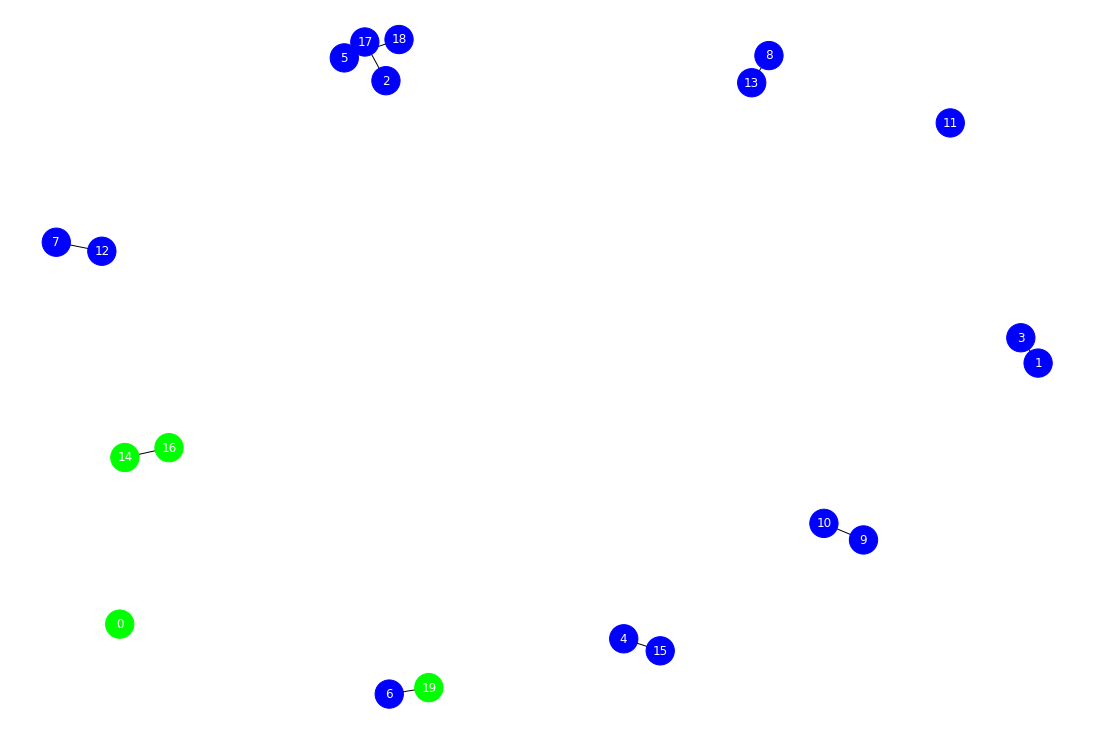

In [12]:
network.interact()

In [13]:
edge_est.network = network

In [14]:
walker = sw.ScoringWalker(
    network, 
    params = {'alpha-scaler':-2, 'walker-steps':3}
)

In [15]:
pandisim = ps.PandiSim(
    network = network, 
    epi_model = sir, 
    scoring_model = walker, 
    edge_model = edge_est, 
    params = {'take_screenshots':True, 'destroy':True}
)

In [16]:
pandisim.take_screenshot()

hdfs://namenode:9000/d_pandisim/step_0/edges.csv
hdfs://namenode:9000/d_pandisim/step_0/vertices.csv


In [17]:
pandisim.move()

[(8, 0.5), (16, 3.6945280494653248), (4, 0.5), (12, 0.5), (0, 0.060454590227163374), (1, 0.5), (13, 0.5), (17, 0.5), (5, 0.5), (9, 0.5), (6, 0.8807970779778823), (2, 0.5), (18, 0.5), (10, 0.5), (14, 3.6945280494653248), (15, 0.5), (7, 0.5), (3, 0.5), (19, 0.8807970779778823), (11, 0.060454590227163374)]


In [18]:
pandisim.take_screenshot()
pandisim.read_state()

hdfs://namenode:9000/d_pandisim/step_1/edges.csv
hdfs://namenode:9000/d_pandisim/step_1/vertices.csv


In [19]:
network.vertices.printSchema()

root
 |-- id: long (nullable = false)
 |-- score: double (nullable = true)
 |-- health_status: double (nullable = false)



+---+---+
|src|dst|
+---+---+
| 15| 18|
| 15| 19|
|  0| 13|
| 15| 17|
|  0| 11|
|  0| 10|
|  0|  9|
|  0| 17|
|  1| 17|
|  0|  1|
|  1|  4|
|  0|  4|
|  1| 14|
|  1| 18|
|  0| 15|
| 15| 16|
|  0| 12|
|  1| 11|
|  0| 18|
|  0|  3|
+---+---+
only showing top 20 rows

+---+--------------------+-------------+
| id|               score|health_status|
+---+--------------------+-------------+
|  0|                 1.0|          1.0|
|  1|  0.0564888762807492|          0.0|
|  2|  0.0564888762807492|          0.0|
|  3|  0.0564888762807492|          0.0|
|  4|  0.0564888762807492|          0.0|
|  5|  0.0564888762807492|          0.0|
|  6|                 1.0|          1.0|
|  7|  0.0564888762807492|          0.0|
|  8|  0.0564888762807492|          0.0|
|  9|  0.0564888762807492|          0.0|
| 10|  0.0564888762807492|          0.0|
| 11|2.847974621404797...|          0.0|
| 12|  0.0564888762807492|          0.0|
| 13|  0.0564888762807492|          0.0|
| 14|                 1.0|          1

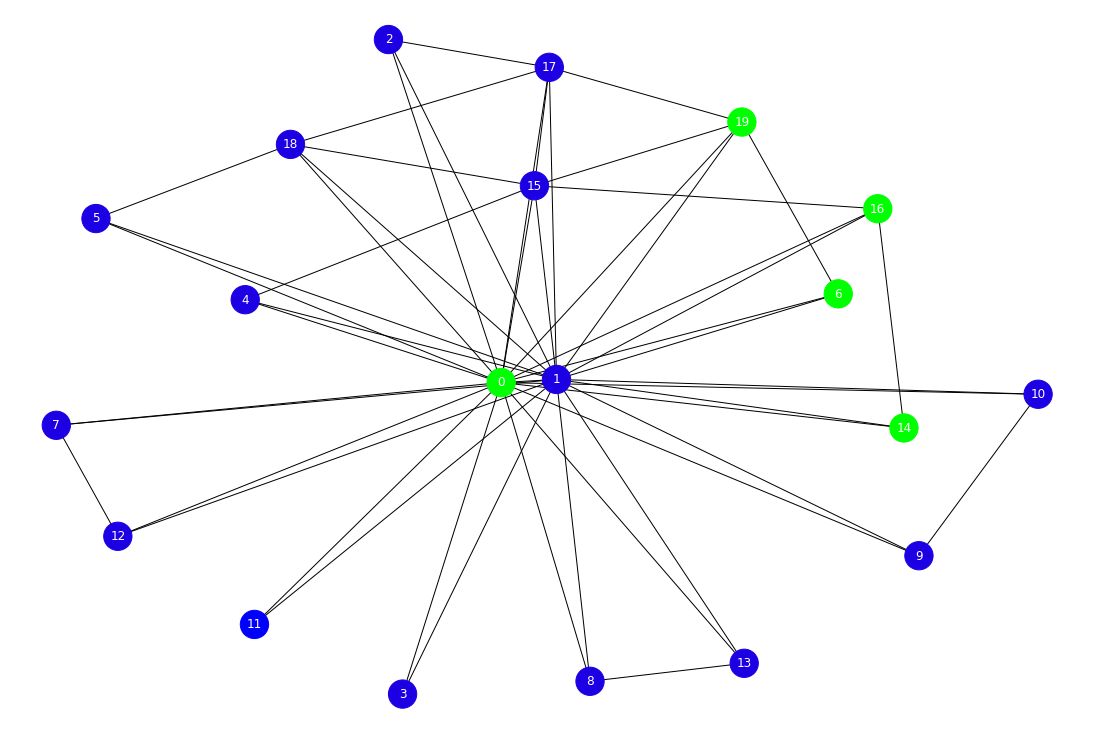

In [20]:
network.interact()

In [21]:
pandisim.move()

[(0, 0.07051685454621673), (8, 0.3552591115394784), (16, 0.4561321910217545), (4, 0.3552591115394784), (12, 0.3552591115394784), (1, 0.07051685454621673), (17, 0.21112532412686488), (13, 0.3552591115394784), (9, 0.3552591115394784), (5, 0.3552591115394784), (18, 0.21733517817618764), (10, 0.3552591115394784), (2, 0.3552591115394784), (6, 0.7697184270868002), (14, 0.7697184270868002), (15, 0.20526047695986901), (7, 0.3552591115394784), (19, 0.32409474874355665), (11, 0.49298753430894265), (3, 0.5203789924570498)]


In [22]:
pandisim.take_screenshot()
pandisim.read_state()

hdfs://namenode:9000/d_pandisim/step_2/edges.csv
hdfs://namenode:9000/d_pandisim/step_2/vertices.csv


+---+---+
|src|dst|
+---+---+
| 15| 18|
| 15| 19|
| 15| 17|
| 15| 16|
| 13| 19|
| 13| 15|
| 13| 14|
| 17| 19|
| 13| 18|
| 13| 16|
| 17| 18|
| 13| 17|
| 15| 18|
| 15| 19|
|  0| 13|
|  1|  3|
| 15| 17|
|  0| 11|
|  0| 10|
|  0|  9|
+---+---+
only showing top 20 rows

+---+--------------------+-------------+
| id|               score|health_status|
+---+--------------------+-------------+
|  0|                 1.0|          1.0|
|  1|                 1.0|          1.0|
|  2| 0.09796379687500582|          0.0|
|  3| 0.08733651273417736|          0.0|
|  4| 0.09932173820750892|          0.0|
|  5| 0.09707096039945018|          0.0|
|  6|                 1.0|          1.0|
|  7| 0.09955774766403563|          0.0|
|  8| 0.09955774766403563|          0.0|
|  9| 0.09955774766403563|          0.0|
| 10| 0.09955774766403563|          0.0|
| 11|0.037936046080877195|          0.0|
| 12| 0.09955774766403563|          0.0|
| 13| 0.09955774766403563|          0.0|
| 14|                 1.0|          1

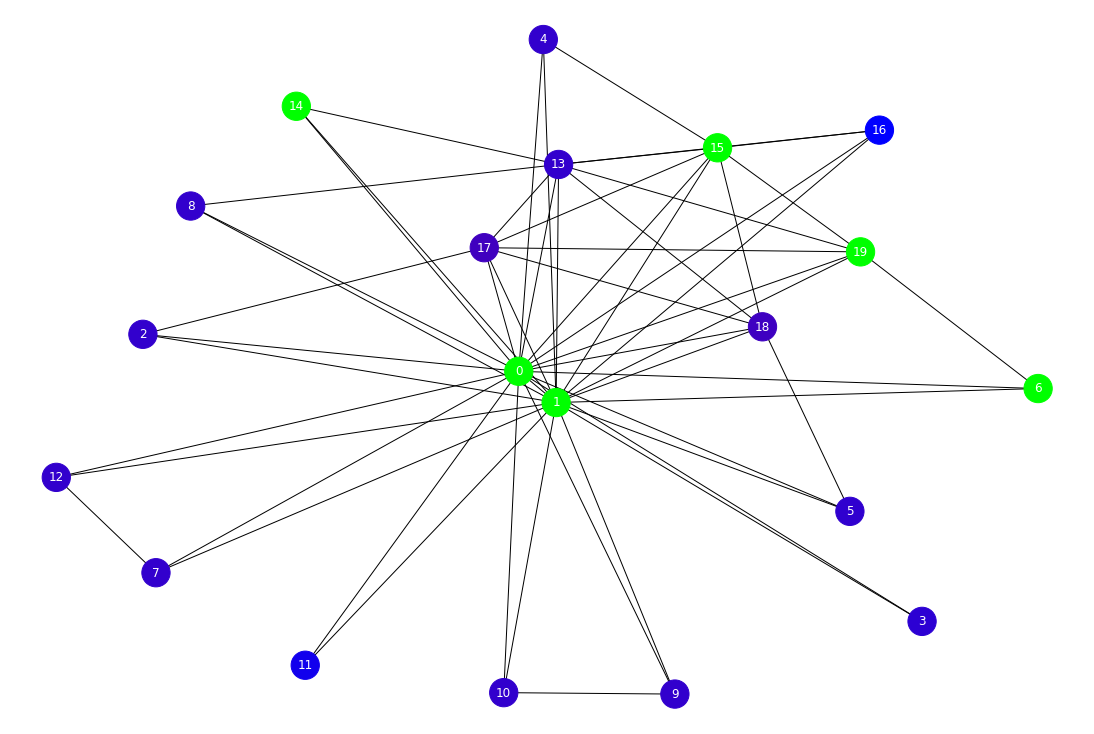

In [23]:
network.interact()